In [10]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from Bio import SeqIO
from collections import OrderedDict
import umap
from scipy import sparse
import umap.plot

%config InlineBackend.figure_format = 'retina'

In [2]:
inputs = [
    '../../../data/examples/humanization_by_translation/common_cdr3/train_pairs/same_len_id50_cdr3split/light/pairs_fa/train.human.fa',
    '../../../data/examples/humanization_by_translation/common_cdr3/train_pairs/same_len_id50_cdr3split/light/pairs_fa/train.mouse.fa'
]
output = 'out2'

In [3]:
names = [os.path.splitext(os.path.basename(path))[0] for path in inputs]
names

['train.human', 'train.mouse']

In [4]:
print(f'Saving to: {output}')
os.makedirs(output, exist_ok=True)

Saving to: out2


In [5]:
fasta_path = os.path.join(output, 'input.fa')
index_path = os.path.join(output, 'index.tsv')
distance_path = os.path.join(output, 'distance.txt')

In [19]:
i = 0
index = []
with open(fasta_path, 'w') as f:
    for path, name in zip(inputs, names):
        for r, record in enumerate(SeqIO.parse(path, 'fasta')):
            if r % 100 == 0:
                index.append(OrderedDict(
                    seq_index=i,
                    seq_id=record.id,
                    name=name
                ))
                record.id = str(i)
                record.description = ''
                record.name = record.id
                SeqIO.write(record, f, 'fasta')
                i += 1
print(f'Wrote {i:,} records to: {fasta_path}')

index = pd.DataFrame(index)
index.to_csv(index_path, sep='\t', index=False)
print(f'Wrote index to: {index_path}')

index.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/examples/humanization_by_translation/common_cdr3/train_pairs/same_len_id50_cdr3split/light/pairs_fa/train.human.fa'

In [49]:
index = pd.read_csv(index_path, sep='\t')
index

,seq_index,seq_id,name
0,0,Waltari_2018_Light_Healthy_cord-blood-cells_Bu...,train.human
1,1,Zhou_2013_IAVI74_mix2_2_iglblastn/239967,train.human
2,2,Gupta_2017_Light_Fv_volunteer_FV_before_8d_SRX...,train.human
3,3,Sheng_2017_Light_LP32647-Light-4_igblastn/120808,train.human
4,4,Soto_2016_Light_IAVI84_Light_iglblastn/750601,train.human
...,...,...,...
12175,12175,Cui_2016_control2_control_mouse_2_iglblastn/11...,test.mouse
12176,12176,Cui_2016_control2_control_mouse_2_iglblastn/92...,test.mouse
12177,12177,Fisher_2017_Light_Naive_IAC2_Naive_Light_iglbl...,test.mouse
12178,12178,Fisher_2017_Light_Naive_IAC1_Naive_Light_iglbl...,test.mouse


In [9]:
!usearch \
    -calc_distmx out2/input.fa \
    -threads 28 \
    -tabbedout out2/distance.txt \
    -maxdist 0.05 \
    -termdist 0.1

usearch v11.0.667_i86linux32, 4.0Gb RAM (264Gb total), 56 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only

00:00 42Mb    100.0% Reading out2/input.fa
00:00 51Mb    100.0% Word stats           
00:00 51Mb    100.0% Alloc rows
00:00 56Mb    100.0% Build index
00:55 665Mb   100.0% Distance matrix/usort


In [51]:
dist_matrix = pd.read_csv(distance_path, header=None, sep='\t')

row = dist_matrix[0]
col = dist_matrix[1]
data = 1-dist_matrix[2]

print(f'Row: {row[-5:]}')
print(f'Col: {col[-5:]}')
print(f'Data: {data[-5:]}')

# TODO csr or csc?
dist_matrix = sparse.csr_matrix((data, (row, col)), dtype=np.float32)
dist_matrix = (1 - dist_matrix.toarray())
dist_matrix.nbytes / 1024 / 1024, 'MB'

Row: 9525128    434
9525129    434
9525130    434
9525131    434
9525132    434
Name: 0, dtype: int64
Col: 9525128    11250
9525129     2946
9525130     2490
9525131    11266
9525132    11269
Name: 1, dtype: int64
Data: 9525128    0.808
9525129    0.809
9525130    0.808
9525131    0.804
9525132    0.802
Name: 2, dtype: float64


(565.9194946289062, 'MB')

In [55]:
fit = umap.UMAP(
    n_neighbors=2,
    metric='precomputed'
)
u = fit.fit_transform(dist_matrix)
u

ValueError: Expected 2D array, got 1D array instead:
array=[0.         0.12300003 0.12300003 ... 1.         1.         1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [53]:
hover_data = index.rename(columns={'seq_index':'index', 'name': 'label'})
p = umap.plot.interactive(fit, labels=index['name'], theme='viridis', hover_data=hover_data);
umap.plot.show(p)

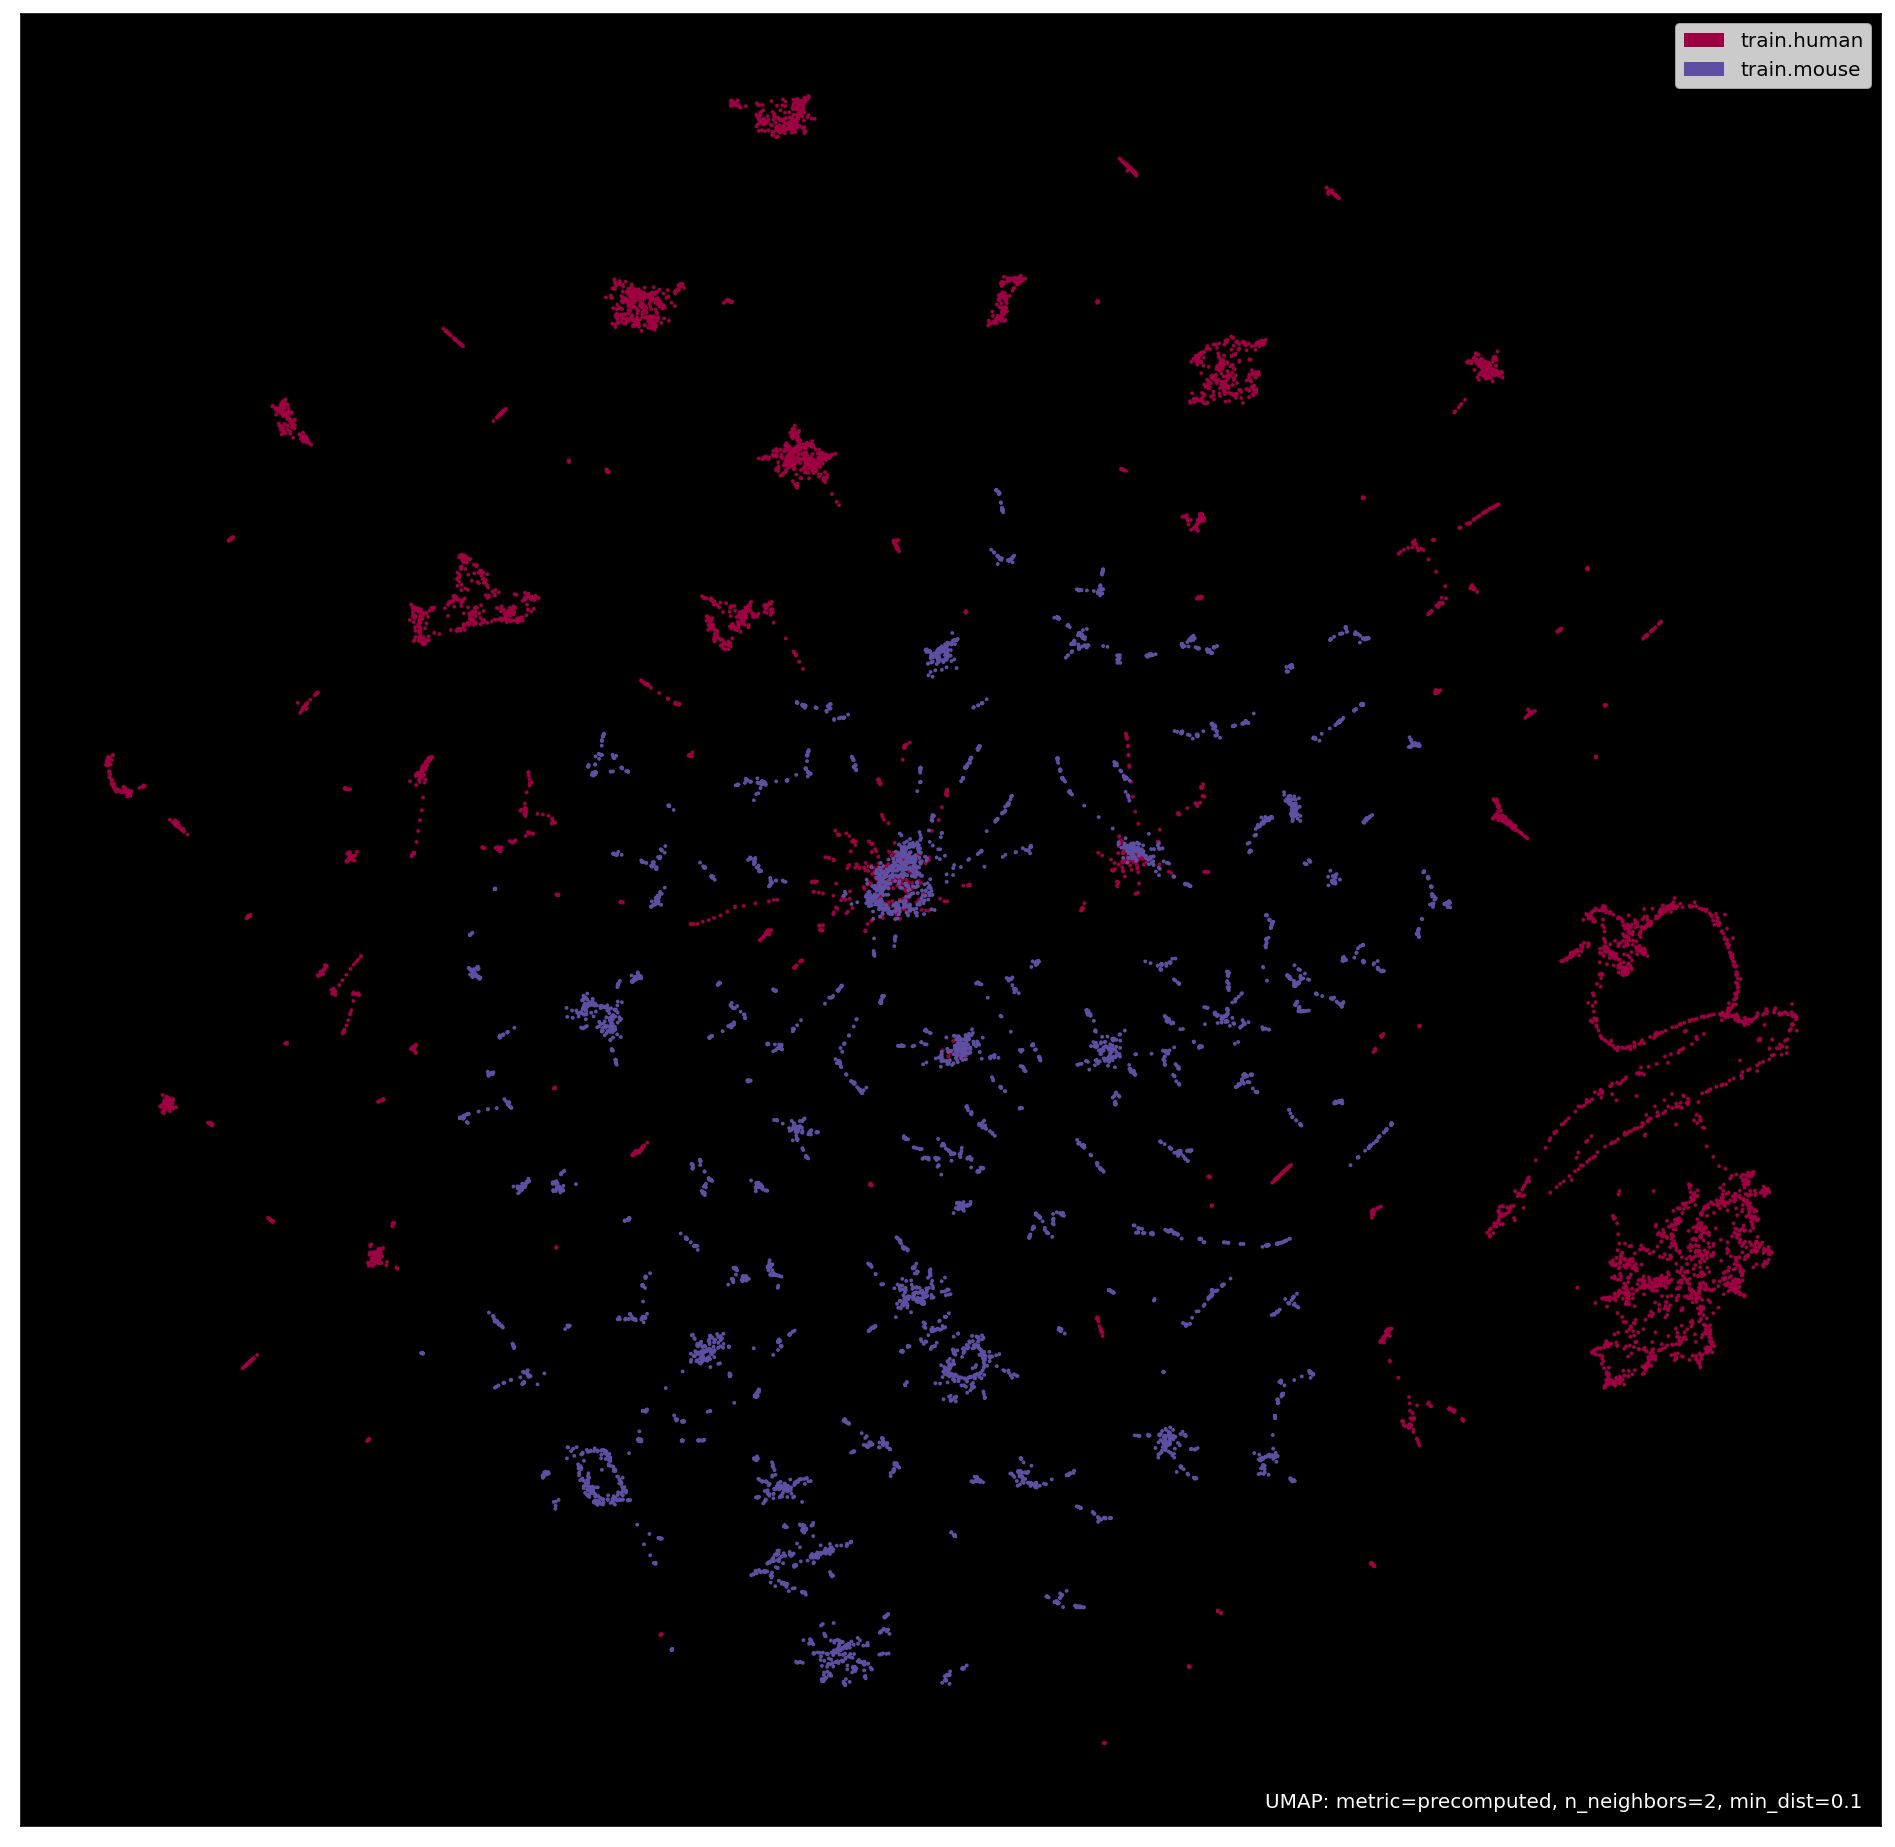

In [41]:
umap.plot.points(fit, labels=index['name'], theme='viridis', width=1200, height=1200);

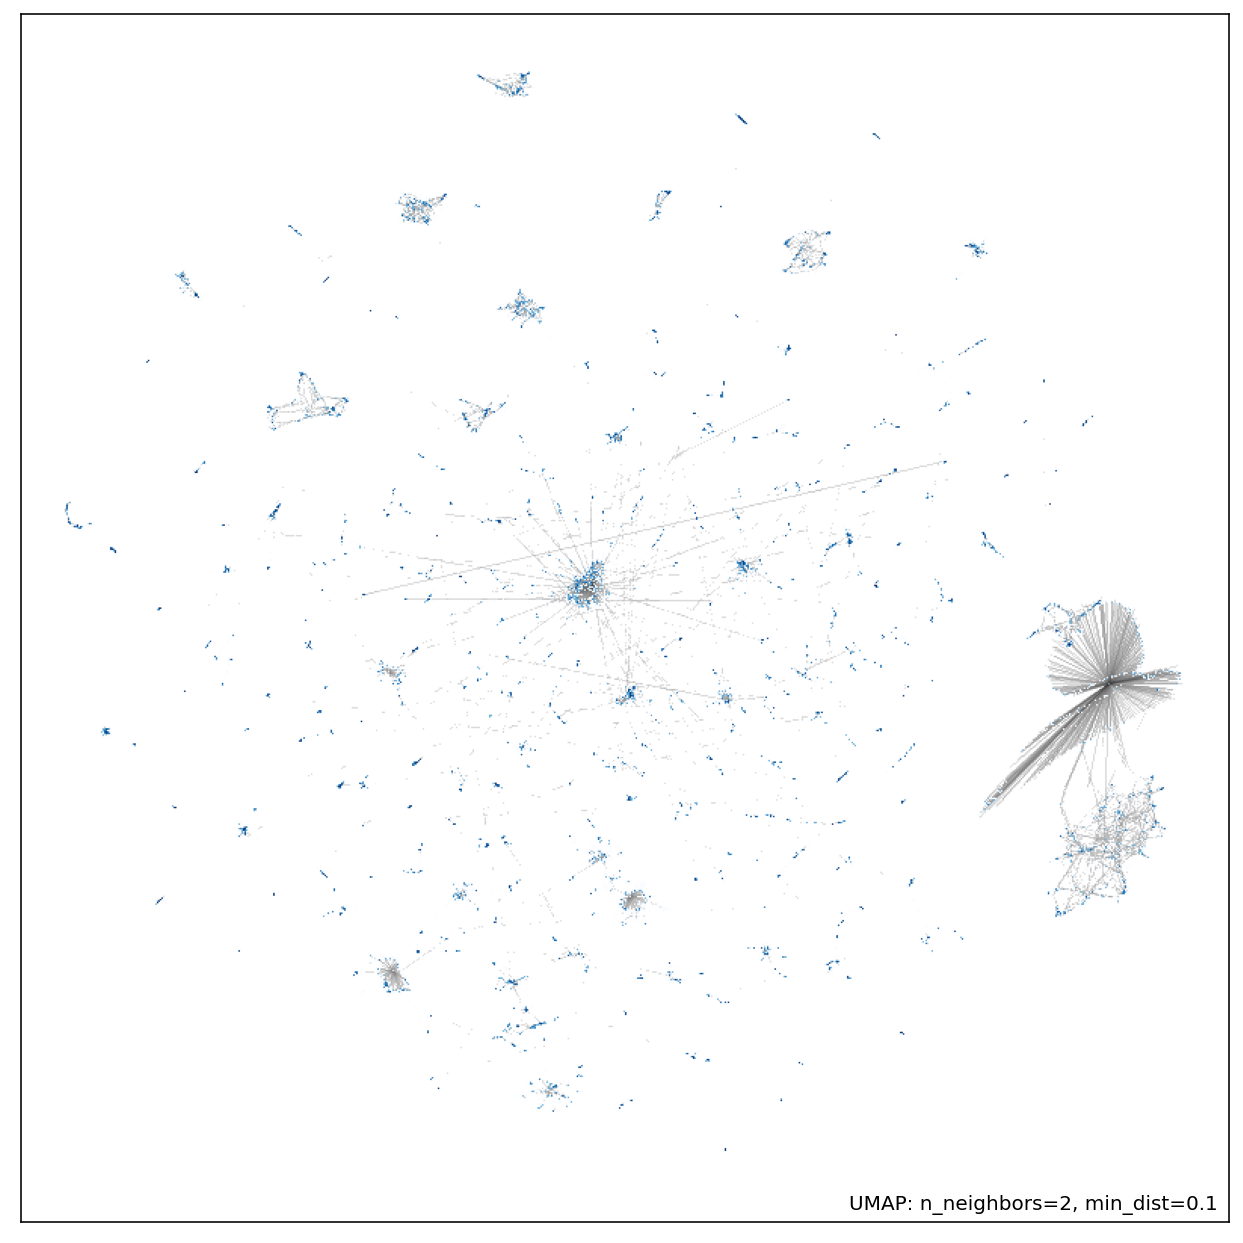

In [33]:
umap.plot.connectivity(fit, show_points=True);